In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import torch

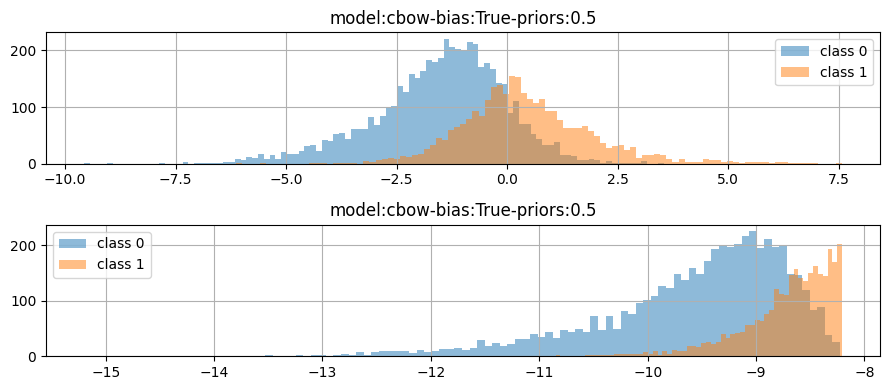

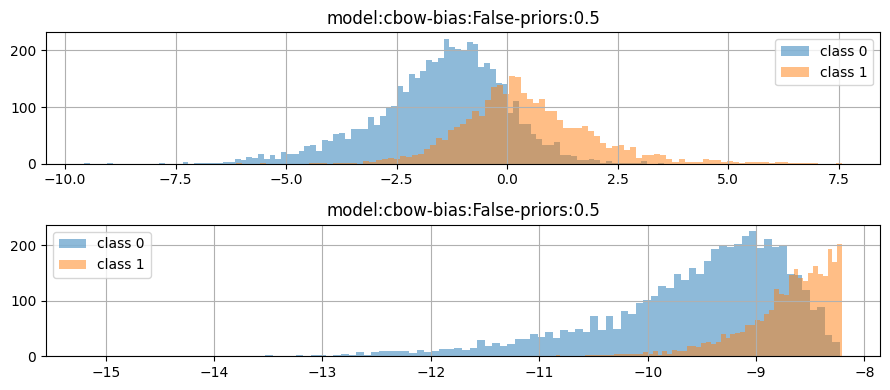

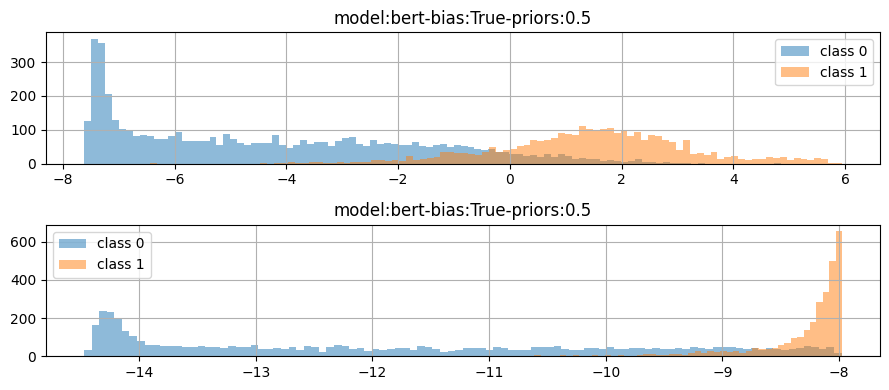

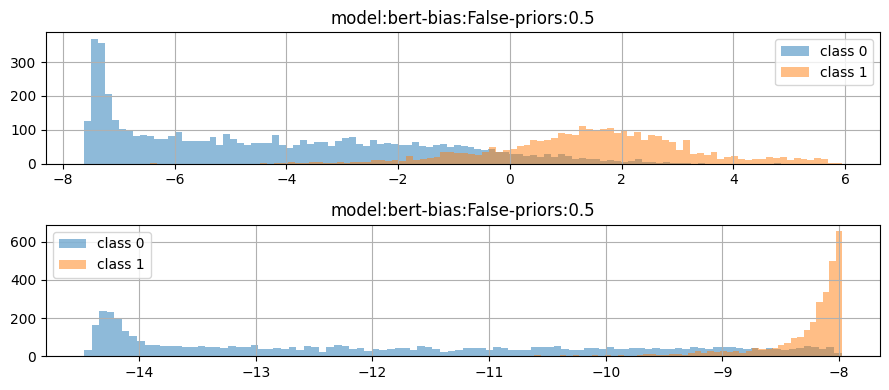

In [60]:
def read_uncalibrated_outputs(model_name):
    with open(f"../results/{model_name}/run00_0/00_Loading Predictions/output.pkl", "rb") as f:
        results = pickle.load(f)
    outputs = results["calibration_validation"]
    logits = outputs.pop("logits")
    logsigmoid = torch.nn.LogSigmoid()
    logpost = logsigmoid(torch.from_numpy(logits)).numpy()
    outputs["logpostiriors"] = logpost
    return outputs

def read_calibrated_outputs(model_name):
    with open(f"../results/{model_name}/run00_0/01_Calibration/results.pkl", "rb") as f:
        results = pickle.load(f)
    return results

def plot_logpostiriors_histograms(model_name):
    nbins = 100
    fig, ax = plt.subplots(2,1,figsize=(9,4))
    for i, read_fn in enumerate([read_uncalibrated_outputs,read_calibrated_outputs]):
        outputs = read_fn(model_name)
        p = outputs["logpostiriors"]
        l = outputs["labels"]
        p_class0 = p[l == 0]
        p_class1 = p[l == 1]
        ax[i].hist(p_class0,bins=nbins,alpha=0.5,label="class 0")
        ax[i].hist(p_class1,bins=nbins,alpha=0.5,label="class 1")
        ax[i].grid(True)
        ax[i].legend()

def plot_llrs_histograms(model_name,prior_class1=0.5,title=""):
    nbins = 100
    fig, ax = plt.subplots(2,1,figsize=(9,4))
    for i, read_fn in enumerate([read_uncalibrated_outputs,read_calibrated_outputs]):
        outputs = read_fn(model_name)
        p = np.exp(outputs["logpostiriors"])
        llrs = np.log(p) - np.log(1-p) - (np.log(prior_class1) - np.log(1 - prior_class1))
        l = outputs["labels"]
        llrs_class0 = llrs[l == 0]
        llrs_class1 = llrs[l == 1]
        ax[i].hist(llrs_class0,bins=nbins,alpha=0.5,label="class 0")
        ax[i].hist(llrs_class1,bins=nbins,alpha=0.5,label="class 1")
        ax[i].grid(True)
        ax[i].legend()
        ax[i].set_title(title)
    
    fig.tight_layout()

for model_name in ["cbow", "bert"]:
    for bias in [True, False]:
        for priors in [None]:
            # plot_logpostiriors_histograms(model_name)
            if priors is None:
                priors=0.5
            plot_llrs_histograms(model_name,prior_class1=priors,title=f"model:{model_name}-bias:{bias}-priors:{priors}")

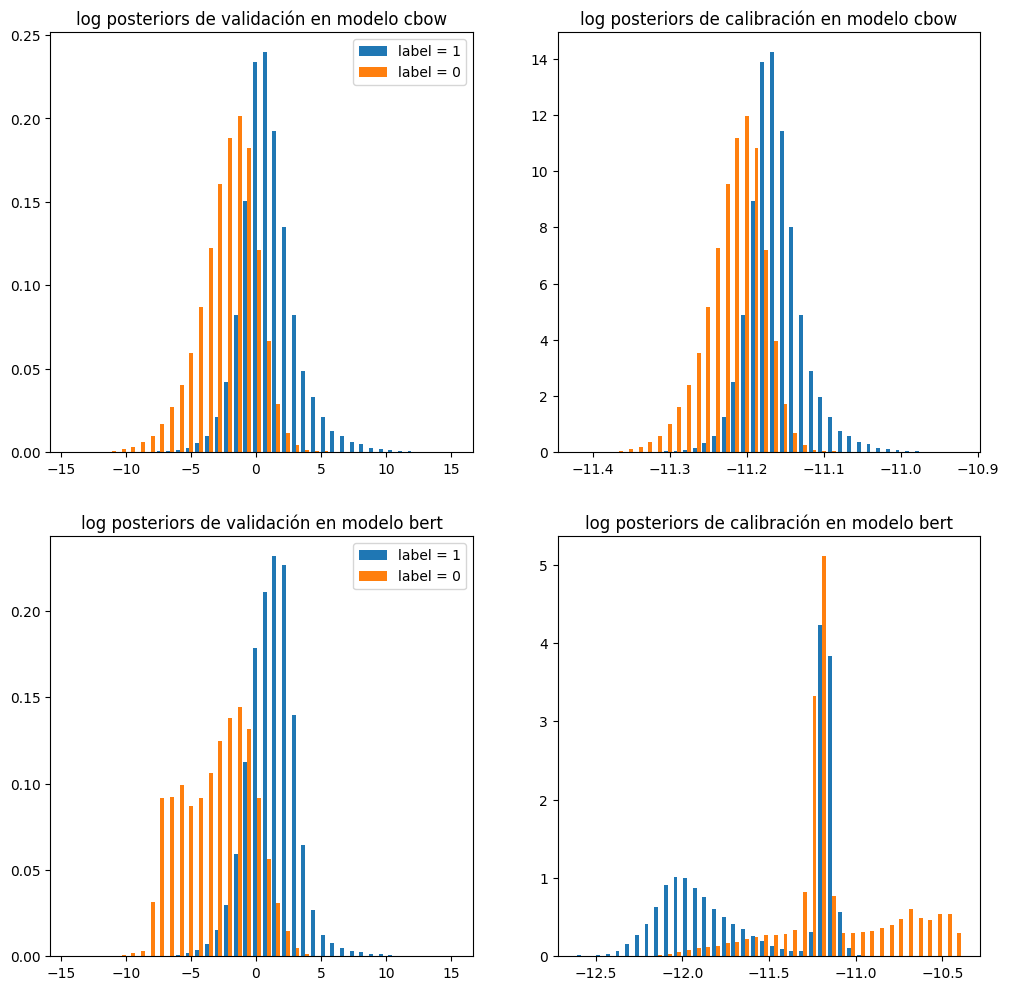

In [24]:

outputs_validation = np.empty(shape=0)
outputs_calibration= np.empty(shape=0)
labels= np.empty(shape=0,dtype=np.int32)
fig, ax = plt.subplots(2, 2, figsize = (12,12))
ax_start=0
for model in ["cbow","bert"]:
   
   with open(path.abspath("../../00_train_system/"+model+"_results.pkl"), 'rb') as f:
      modelOutputs = pkl.load(f)
   calibrationOutputs = np.load(path.abspath(f"../../01_calibrate_system/results/{model}/run00_0/00_Calibration/results.npz"))

   outputs_validation = np.append(outputs_validation,modelOutputs["validation"]["logits"])
   outputs_calibration = np.append(outputs_calibration,calibrationOutputs["logits"])
   labels = np.append(labels,modelOutputs["validation"]["labels"])    

   


   class_1_labels = np.where(labels == 0)[0]
   class_2_labels = np.where(labels == 1)[0]
   ax[ax_start][0].set_title(f"log posteriors de validación en modelo "+model)

   ax[ax_start][0].hist([outputs_validation[class_2_labels], outputs_validation[class_1_labels]], 40, label=['label = 1', 'label = 0'],density=True)
   ax[ax_start][0].legend(loc='upper right')

   ax[ax_start][1].set_title(f"log posteriors de calibración en modelo "+model)

   ax[ax_start][1].hist([outputs_calibration[class_2_labels], outputs_calibration[class_1_labels]], 40, label=['label = 1', 'label = 0'],density=True);

   ax_start +=1

